In [8]:
#setting up colab for downloading kaggle datasets directly
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
!kaggle datasets download -d puneet6060/intel-image-classification #download the dataset

 95% 329M/346M [00:03<00:00, 117MB/s]
100% 346M/346M [00:03<00:00, 112MB/s]


In [0]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [11]:
#extract the data
for file in os.listdir():
    if '.zip' in file:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
      print('done')

done


In [0]:
train_dir = '/content/seg_train/seg_train'
val_dir = '/content/seg_test/seg_test'
#os.listdir(train_dir)

In [13]:
print('Training data distribution\n')
for class_folder in os.listdir(train_dir):
  print(class_folder, '->', str(len(os.listdir(train_dir+'/'+class_folder))), ' images')
print('\nValidation Data distribution\n')
for class_folder in os.listdir(val_dir):
  print(class_folder, '->', str(len(os.listdir(val_dir+'/'+class_folder))), ' images')

Training data distribution

glacier -> 2404  images
mountain -> 2512  images
sea -> 2274  images
forest -> 2271  images
buildings -> 2191  images
street -> 2382  images

Validation Data distribution

glacier -> 553  images
mountain -> 525  images
sea -> 510  images
forest -> 474  images
buildings -> 437  images
street -> 501  images


In [0]:
#initialize data generators and used image augmentation for reducing overfitting ->image rotation, shear, zoom , horizontal flipping, height and width reduction
train_gen = ImageDataGenerator(rescale=1/255.0, rotation_range=45, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
val_gen = ImageDataGenerator(rescale=1/255.0, rotation_range=45, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

In [46]:
#provide the directories for the generators
train_data = train_gen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=64, class_mode='categorical')
val_data = val_gen.flow_from_directory(directory=val_dir, target_size=(150, 150), batch_size=64, class_mode='categorical', shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.01, patience=5, verbose=1) #initialize early stopping

In [0]:
num_classes = train_data.num_classes #find number of classes of data
#initialize the model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3), padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision()]) #compile the model with loss function, optimizer function and metrics

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 64)      4864      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 128)       204928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 512)      

In [38]:
history = model.fit(train_data, steps_per_epoch=220, epochs=50, validation_data=val_data, validation_steps=47, callbacks=[callback]) #model.fit supports generators

Epoch 1/50
220/220 [==============================] - 91s 413ms/step - loss: 1.2802 - categorical_accuracy: 0.4706 - precision_1: 0.6913 - val_loss: 1.0487 - val_categorical_accuracy: 0.5807 - val_precision_1: 0.7151
Epoch 2/50
220/220 [==============================] - 91s 412ms/step - loss: 1.0372 - categorical_accuracy: 0.5865 - precision_1: 0.7262 - val_loss: 0.9459 - val_categorical_accuracy: 0.6400 - val_precision_1: 0.7555
Epoch 3/50
220/220 [==============================] - 90s 411ms/step - loss: 0.9257 - categorical_accuracy: 0.6424 - precision_1: 0.7424 - val_loss: 0.9188 - val_categorical_accuracy: 0.6437 - val_precision_1: 0.7156
Epoch 4/50
220/220 [==============================] - 90s 411ms/step - loss: 0.8495 - categorical_accuracy: 0.6798 - precision_1: 0.7598 - val_loss: 0.8588 - val_categorical_accuracy: 0.6787 - val_precision_1: 0.7529
Epoch 5/50
220/220 [==============================] - 91s 412ms/step - loss: 0.7705 - categorical_accuracy: 0.7146 - precision_1: 0.

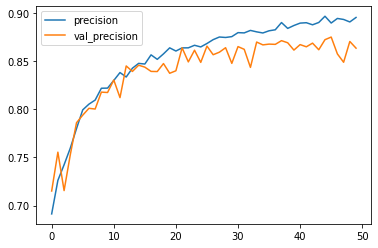

In [41]:
plt.plot(history.history['precision_1'], label='precision')
plt.plot(history.history['val_precision_1'], label='val_precision')
plt.legend()
plt.show()

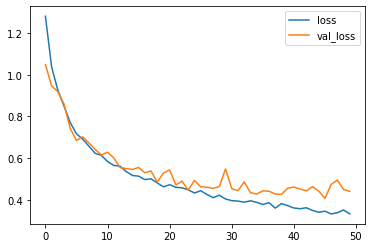

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

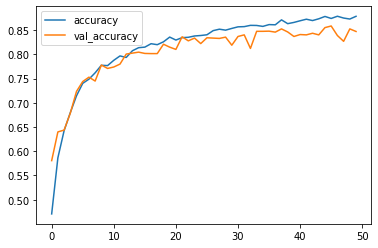

In [43]:
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [0]:
pred_dir = '/content/seg_pred/seg_pred'

In [44]:
val_data.reset()
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis = 1)

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   buildings       0.79      0.84      0.81       437
      forest       0.96      0.97      0.97       474
     glacier       0.81      0.79      0.80       553
    mountain       0.81      0.78      0.79       525
         sea       0.83      0.84      0.84       510
      street       0.86      0.87      0.87       501

    accuracy                           0.84      3000
   macro avg       0.84      0.85      0.85      3000
weighted avg       0.84      0.84      0.84      3000



In [0]:
def image_display(img_path):
  img=mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  plt.show()

In [0]:
def predict(img_path):
  img = image.load_img(img_path, target_size=(150, 150))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)
  return pred

In [0]:
def find(classes, index):
  for key, value in classes.items():
    if value == index:
      print(key)

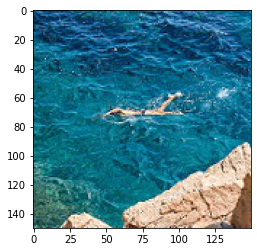

buildings


In [29]:
preds = []
val_data.reset()
classes = val_data.class_indices
path = pred_dir+'/4588.jpg'
image_display(path)
pred = np.argmax(predict(path), axis=1)
find(classes , pred)